<a href="https://colab.research.google.com/github/Jmontoyaor/Computational-electromagnetics/blob/main/Workshop2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ejemplo 16,5

               MÉTODO DE GALERKIN - LÍNEA MICROSTRIP

📋 PARÁMETROS DEL PROBLEMA:
   • Ancho del conductor (W): 10 mm
   • Altura del dieléctrico (h): 1.6 mm
   • Separación placas (d): 30 mm
   • Permitividad relativa (εᵣ): 4.3
   • Voltaje aplicado (V₀): 10 V
   • Términos en la serie (N): 151

📊 Generando gráficas...



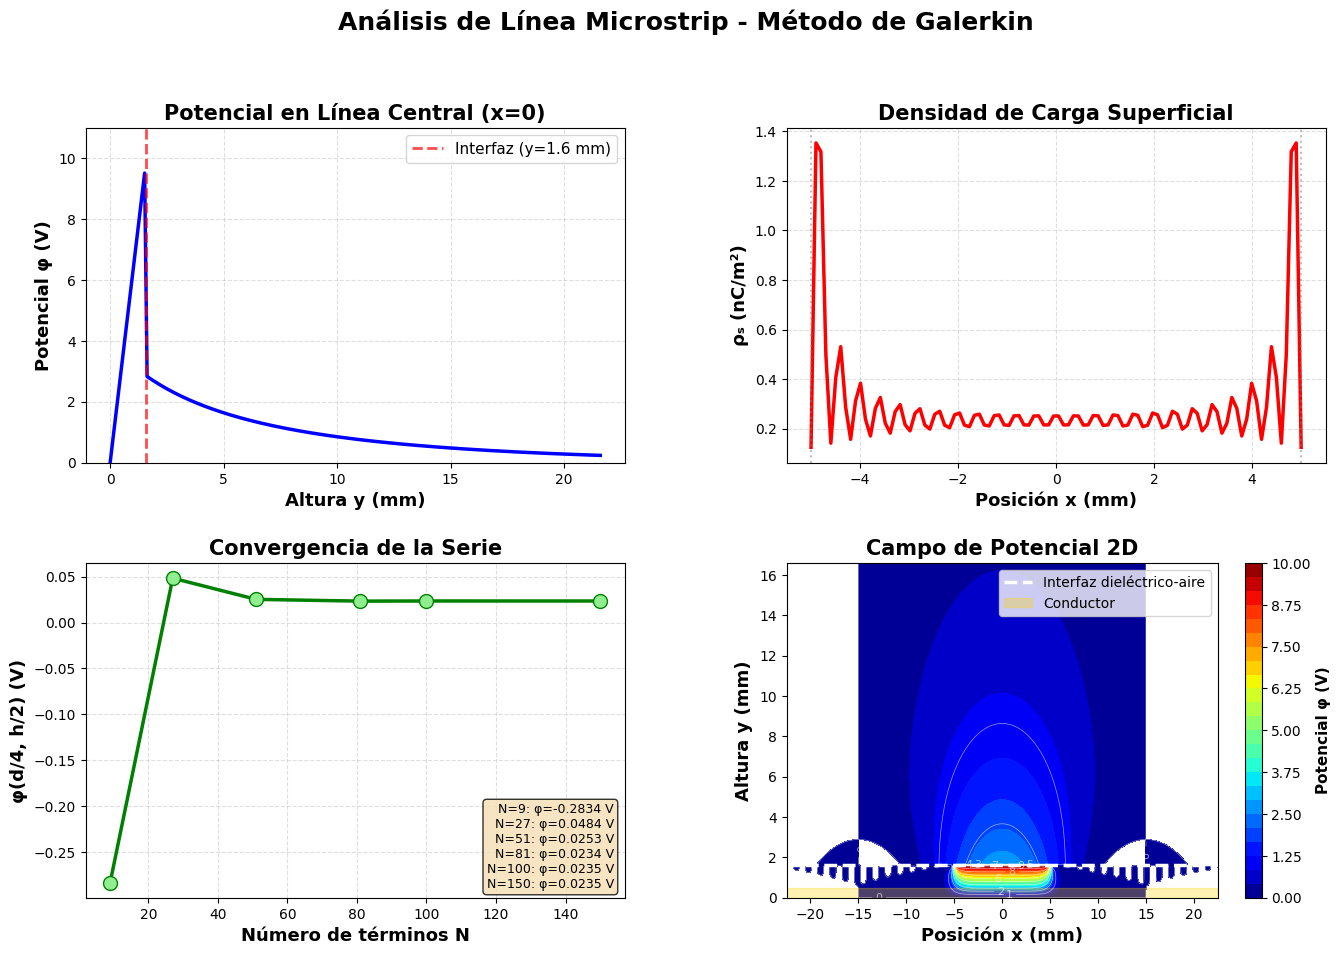

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.html'] = 'html5'

class MicrostripGalerkin:
    def __init__(self, W=40, h=16, d=0.03, er=4.3, V0=10, N=51):
        """
        W: Ancho del conductor (mm)
        h: Altura del dieléctrico (mm)
        d: Separación entre placas (mm)
        er: Permitividad relativa
        V0: Voltaje aplicado (V)
        N: Número de términos
        """
        self.W = W
        self.h = h
        self.d = d
        self.er = er
        self.V0 = V0
        self.N = N if N % 2 == 1 else N + 1

    def calculate_An(self, n):
        """Coeficiente An para región dieléctrica"""
        n_pi = n * np.pi

        # sin(nπW/2d)
        numerator = np.sin(n_pi * self.W / (2 * self.d))

        # sinh(nπh/d)
        denominator = np.sinh(n_pi * self.h / self.d)

        if abs(denominator) < 1e-100:
            return 0

        # An = (4V0/nπ) * [sin(nπW/2d) / sinh(nπh/d)]
        return (4 * self.V0 / n_pi) * (numerator / denominator)

    def calculate_Bn(self, n):
        """Coeficiente Bn para región del aire"""
        n_pi = n * np.pi

        # sin(nπW/2d)
        sin_term = np.sin(n_pi * self.W / (2 * self.d))

        # exp(-nπW/2d)
        exp_term = np.exp(-n_pi * self.W / (2 * self.d))

        # Bn = (4V0/nπ) * sin(nπW/2d) * exp(-nπW/2d)
        return (4 * self.V0 / n_pi) * sin_term * exp_term

    def potential_dielectric(self, x, y, n_terms=None):
        """Potencial en dieléctrico: φ(x,y) = Σ An sinh(nπy/d) cos(nπx/d)"""
        if n_terms is None:
            n_terms = self.N

        phi = 0
        for n in range(1, n_terms + 1, 2):
            An = self.calculate_An(n)
            n_pi = n * np.pi

            sinh_term = np.sinh(n_pi * y / self.d)
            cos_term = np.cos(n_pi * x / self.d)

            phi += An * sinh_term * cos_term

        return phi

    def potential_air(self, x, y, n_terms=None):
        """Potencial en aire: φ(x,y) = Σ Bn exp(-nπ(y-h)/d) sin(nπW/2d) cos(nπx/d)"""
        if n_terms is None:
            n_terms = self.N

        phi = 0
        for n in range(1, n_terms + 1, 2):
            Bn = self.calculate_Bn(n)
            n_pi = n * np.pi

            exp_term = np.exp(-n_pi * (y - self.h) / self.d)
            sin_w = np.sin(n_pi * self.W / (2 * self.d))
            cos_term = np.cos(n_pi * x / self.d)

            phi += Bn * exp_term * sin_w * cos_term

        return phi

    def calculate_center_line(self, num_points=200, n_terms=None):
        """Potencial en línea central x=0"""
        y_max = self.h + 20
        y_values = np.linspace(0, y_max, num_points)
        phi_values = np.zeros(num_points)

        for i, y in enumerate(y_values):
            if y <= self.h:
                phi_values[i] = self.potential_dielectric(0, y, n_terms)
            else:
                phi_values[i] = self.potential_air(0, y, n_terms)

        return y_values, phi_values

    def calculate_charge_density(self, num_points=100):
        """Densidad de carga superficial en y=h"""
        e0 = 8.854e-12  # F/m

        x_values = np.linspace(-self.W/2, self.W/2, num_points)
        rho_values = np.zeros(num_points)

        for i, x in enumerate(x_values):
            sum_diel = 0
            sum_air = 0

            for n in range(1, self.N + 1, 2):
                An = self.calculate_An(n)
                Bn = self.calculate_Bn(n)
                n_pi = n * np.pi

                # Derivada en y en el dieléctrico
                cosh_term = np.cosh(n_pi * self.h / self.d)
                cos_term = np.cos(n_pi * x / self.d)

                sum_diel += (n_pi / self.d) * An * cosh_term * cos_term

                # Derivada en y en el aire
                sin_w = np.sin(n_pi * self.W / (2 * self.d))
                sum_air += (n_pi / self.d) * Bn * sin_w * cos_term

            # ρs = ε0 * [εr * (∂φ/∂y)|diel - (∂φ/∂y)|aire]
            rho = e0 * (self.er * sum_diel - sum_air)
            rho_values[i] = rho * 1e9  # Convertir a nC/m²

        return x_values, rho_values

    def calculate_convergence(self):
        """Convergencia evaluando en un punto"""
        n_values = [9, 27, 51, 81, 100, 150]
        n_values = [n for n in n_values if n <= self.N]
        phi_values = []

        for n in n_values:
            # Evaluar en (x=d/4, y=h/2)
            phi = self.potential_dielectric(self.d/4, self.h/2, n)
            phi_values.append(phi)

        return np.array(n_values), np.array(phi_values)

    def calculate_field_2d(self, x_points=150, y_points=150):
        """Campo 2D de potencial"""
        x_range = self.d * 1.5
        x_values = np.linspace(-x_range/2, x_range/2, x_points)
        y_values = np.linspace(0, self.h + 15, y_points)

        X, Y = np.meshgrid(x_values, y_values)
        phi_field = np.zeros_like(X)

        for i in range(y_points):
            for j in range(x_points):
                x, y = X[i, j], Y[i, j]
                if y <= self.h:
                    phi_field[i, j] = self.potential_dielectric(x, y)
                else:
                    phi_field[i, j] = self.potential_air(x, y)

        return X, Y, phi_field


def plot_results(microstrip):
    """Gráficas de resultados"""
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

    # 1. Potencial en línea central
    ax1 = fig.add_subplot(gs[0, 0])
    y_vals, phi_vals = microstrip.calculate_center_line()
    ax1.plot(y_vals, phi_vals, 'b-', linewidth=2.5)
    ax1.axvline(x=microstrip.h, color='red', linestyle='--', linewidth=2,
                alpha=0.7, label=f'Interfaz (y={microstrip.h} mm)')
    ax1.set_xlabel('Altura y (mm)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Potencial φ (V)', fontsize=13, fontweight='bold')
    ax1.set_title('Potencial en Línea Central (x=0)', fontsize=15, fontweight='bold')
    ax1.grid(True, alpha=0.4, linestyle='--')
    ax1.legend(fontsize=11)
    ax1.set_ylim([0, microstrip.V0 * 1.1])

    # 2. Densidad de carga
    ax2 = fig.add_subplot(gs[0, 1])
    x_vals, rho_vals = microstrip.calculate_charge_density()
    ax2.plot(x_vals, rho_vals, 'r-', linewidth=2.5)
    ax2.axvline(x=-microstrip.W/2, color='gray', linestyle=':', alpha=0.5)
    ax2.axvline(x=microstrip.W/2, color='gray', linestyle=':', alpha=0.5)
    ax2.set_xlabel('Posición x (mm)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('ρₛ (nC/m²)', fontsize=13, fontweight='bold')
    ax2.set_title('Densidad de Carga Superficial', fontsize=15, fontweight='bold')
    ax2.grid(True, alpha=0.4, linestyle='--')

    # 3. Convergencia
    ax3 = fig.add_subplot(gs[1, 0])
    n_vals, conv_vals = microstrip.calculate_convergence()
    ax3.plot(n_vals, conv_vals, 'go-', linewidth=2.5, markersize=10, markerfacecolor='lightgreen')
    ax3.set_xlabel('Número de términos N', fontsize=13, fontweight='bold')
    ax3.set_ylabel('φ(d/4, h/2) (V)', fontsize=13, fontweight='bold')
    ax3.set_title('Convergencia de la Serie', fontsize=15, fontweight='bold')
    ax3.grid(True, alpha=0.4, linestyle='--')

    # Agregar tabla de convergencia
    table_text = '\n'.join([f'N={n}: φ={v:.4f} V' for n, v in zip(n_vals, conv_vals)])
    ax3.text(0.98, 0.02, table_text, transform=ax3.transAxes,
             fontsize=9, verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # 4. Campo 2D
    ax4 = fig.add_subplot(gs[1, 1])
    X, Y, phi_field = microstrip.calculate_field_2d()

    levels = np.linspace(0, microstrip.V0, 25)
    contour = ax4.contourf(X, Y, phi_field, levels=levels, cmap='jet')

    # Líneas de contorno
    contour_lines = ax4.contour(X, Y, phi_field, levels=10, colors='white',
                                linewidths=0.5, alpha=0.6)
    ax4.clabel(contour_lines, inline=True, fontsize=8)

    # Interfaz
    ax4.axhline(y=microstrip.h, color='white', linestyle='--', linewidth=2.5,
                label='Interfaz dieléctrico-aire')

    # Conductor
    conductor_width = microstrip.W/2
    ax4.fill_between([X.min(), X.max()], 0, 0.5,
                     color='gold', alpha=0.3, label='Conductor')

    cbar = plt.colorbar(contour, ax=ax4)
    cbar.set_label('Potencial φ (V)', fontsize=11, fontweight='bold')
    ax4.set_xlabel('Posición x (mm)', fontsize=13, fontweight='bold')
    ax4.set_ylabel('Altura y (mm)', fontsize=13, fontweight='bold')
    ax4.set_title('Campo de Potencial 2D', fontsize=15, fontweight='bold')
    ax4.legend(fontsize=10, loc='upper right')

    plt.suptitle('Análisis de Línea Microstrip - Método de Galerkin',
                 fontsize=18, fontweight='bold', y=0.998)

    return fig


def animate_convergence(microstrip, n_max=151):
    """Animación de convergencia"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    y_vals = np.linspace(0, microstrip.h + 20, 200)
    n_values = list(range(1, min(n_max, microstrip.N) + 1, 2))

    # Gráfica 1: Potencial
    line1, = ax1.plot([], [], 'b-', linewidth=2.5)
    ax1.axvline(x=microstrip.h, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax1.set_xlim(0, microstrip.h + 20)
    ax1.set_ylim(0, microstrip.V0 * 1.1)
    ax1.set_xlabel('Altura y (mm)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Potencial φ (V)', fontsize=12, fontweight='bold')
    ax1.set_title('Potencial en Línea Central (x=0)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.4)
    text1 = ax1.text(0.02, 0.95, '', transform=ax1.transAxes,
                     fontsize=13, verticalalignment='top', fontweight='bold',
                     bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

    # Gráfica 2: Convergencia
    line2, = ax2.plot([], [], 'go-', linewidth=2.5, markersize=10)
    ax2.set_xlabel('Número de términos N', fontsize=12, fontweight='bold')
    ax2.set_ylabel('φ(d/4, h/2) (V)', fontsize=12, fontweight='bold')
    ax2.set_title('Convergencia de la Serie', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.4)
    ax2.set_xlim(0, n_max)

    n_conv = []
    phi_conv = []

    def init():
        line1.set_data([], [])
        line2.set_data([], [])
        return line1, line2, text1

    def animate(frame):
        n = n_values[frame]

        # Potencial con n términos
        phi_vals = np.zeros_like(y_vals)
        for i, y in enumerate(y_vals):
            if y <= microstrip.h:
                phi_vals[i] = microstrip.potential_dielectric(0, y, n)
            else:
                phi_vals[i] = microstrip.potential_air(0, y, n)

        line1.set_data(y_vals, phi_vals)
        text1.set_text(f'N = {n} términos')

        # Convergencia
        phi_center = microstrip.potential_dielectric(microstrip.d/4, microstrip.h/2, n)
        n_conv.append(n)
        phi_conv.append(phi_center)

        line2.set_data(n_conv, phi_conv)
        if len(phi_conv) > 1:
            y_min, y_max = min(phi_conv), max(phi_conv)
            margin = (y_max - y_min) * 0.1 if y_max != y_min else 1
            ax2.set_ylim(y_min - margin, y_max + margin)

        return line1, line2, text1

    ani = FuncAnimation(fig, animate, init_func=init,
                       frames=len(n_values), interval=150,
                       blit=True, repeat=True)

    plt.tight_layout()

    video = ani.to_html5_video()
    plt.close()
    return HTML(video)


# ============= EJECUCIÓN =============

print("="*70)
print(" "*15 + "MÉTODO DE GALERKIN - LÍNEA MICROSTRIP")
print("="*70)

# Crear instancia
microstrip = MicrostripGalerkin(
   W=10,     # mm
    h=1.6,    # mm
    d=30,
    er=4.3,
    V0=10,    # V
    N=151
)

print(f"\n📋 PARÁMETROS DEL PROBLEMA:")
print(f"   • Ancho del conductor (W): {microstrip.W} mm")
print(f"   • Altura del dieléctrico (h): {microstrip.h} mm")
print(f"   • Separación placas (d): {microstrip.d} mm")
print(f"   • Permitividad relativa (εᵣ): {microstrip.er}")
print(f"   • Voltaje aplicado (V₀): {microstrip.V0} V")
print(f"   • Términos en la serie (N): {microstrip.N}")

print("\n" + "="*70)
print("📊 Generando gráficas...")
print("="*70 + "\n")

# Gráficas estáticas
fig_static = plot_results(microstrip)
plt.show()



In [9]:
# Animación
print("\n🎬 Generando animación de convergencia...\n")
animate_convergence(microstrip, n_max=151)


🎬 Generando animación de convergencia...



# Ejemplo 16.7 usando FDTD (Finite Difference Time Domain) y FEM (Finite Element Method):



--- Verificación de la Tabla 16.1 ---
Cálculo de phi(x=d/4, y=h/2) para diferentes N:
Para N =   9, phi = -0.2834 V
Para N =  27, phi =  0.0484 V
Para N =  51, phi =  0.0253 V
Para N = 100, phi =  0.0235 V
Para N = 150, phi =  0.0235 V


Nota: El valor de N=9 (-2.709 V) en el texto parece ser un error tipográfico.
Los valores calculados aquí para N > 27 coinciden con la Tabla 16.1.
-----------------------------------------

Calculando potencial en la malla (puede tardar un momento)...
Cálculo completo.


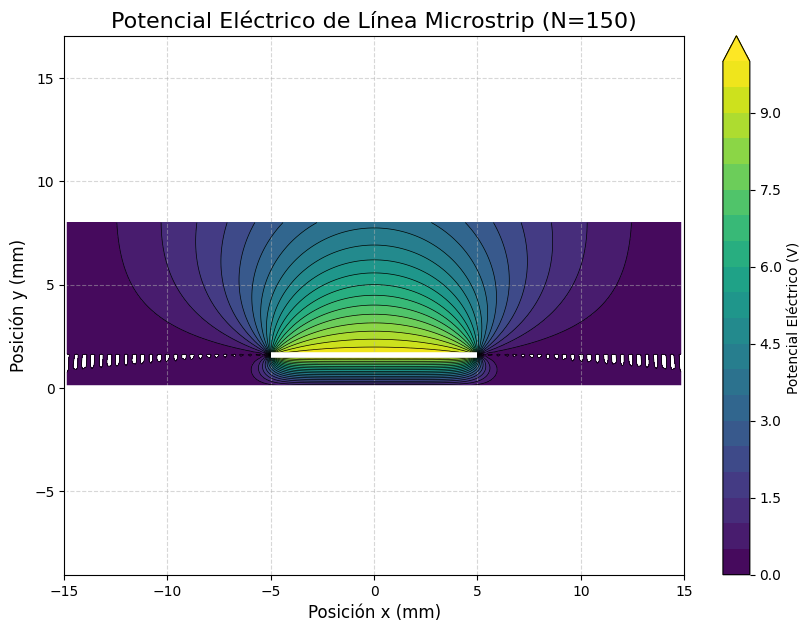

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Constantes del Problema (Ejemplo 16.5) ---
# Se convierten todas las unidades a metros (Sistema Internacional)
d = 30e-3     # Ancho de la caja (30 mm)
W = 10e-3     # Ancho de la tira (10 mm)
h = 1.6e-3    # Alto del dieléctrico (1.6 mm)
V0 = 10.0     # Potencial de la tira (10 V)

# Nota: Los valores de t (espesor) y epsilon_r no se usan en este modelo
# simplificado (se asume t=0 y la solución se divide en dos regiones).


# --- 2. Verificación de la Tabla 16.1 ---
# Cálculo del potencial en el punto (x = d/4, y = h/2)

print("--- Verificación de la Tabla 16.1 ---")
print("Cálculo de phi(x=d/4, y=h/2) para diferentes N:")

x_point = d / 4.0
y_point = h / 2.0

# Lista de valores de N para la tabla
N_values = [9, 27, 51, 100, 150]

for N in N_values:
    phi_sum = 0.0

    # n_array es el arreglo de números impares [1, 3, 5, ..., N]
    n_array = np.arange(1, N + 1, 2)

    # Argumentos trigonométricos e hiperbólicos
    arg_sin = (n_array * np.pi * W) / (2 * d)
    arg_sinh_h = (n_array * np.pi * h) / d
    arg_sinh_y = (n_array * np.pi * y_point) / d
    arg_cos_x = (n_array * np.pi * x_point) / d

    # Calcular An (coeficiente)
    An = (4 * V0) / (n_array * np.pi) * np.sin(arg_sin) / np.sinh(arg_sinh_h)

    # Sumar todos los términos de la serie
    terms = An * np.sinh(arg_sinh_y) * np.cos(arg_cos_x)
    phi_sum = np.sum(terms)

    print(f"Para N = {N:3}, phi = {phi_sum:7.4f} V")

print("\n")
print("Nota: El valor de N=9 (-2.709 V) en el texto parece ser un error tipográfico.")
print("Los valores calculados aquí para N > 27 coinciden con la Tabla 16.1.")
print("-----------------------------------------\n")


# --- 3. Función Vectorizada para el Potencial (para Graficar) ---

def get_potential(x, y, N):
    """
    Calcula el potencial phi(x,y) usando N términos impares de la serie.
    Usa numpy de forma vectorizada para ser eficiente.

    x, y deben tener la forma (nx, ny, 1)
    """

    # Crear un vector columna para n [1, 3, 5, ..., N]
    # La forma (1, 1, -1) permite hacer 'broadcasting' con la malla (X, Y)
    n = np.arange(1, N + 1, 2).reshape((1, 1, -1))

    # Calcular argumentos comunes
    # (X, Y) tienen forma (nx, ny, 1)
    # n tiene forma (1, 1, N_terms)
    # El resultado tendrá forma (nx, ny, N_terms)
    arg_cos_x = (n * np.pi * x) / d
    arg_sin_W = (n * np.pi * W) / (2 * d)
    arg_sinh_h = (n * np.pi * h) / d

    # Coeficiente C_n (para la región de aire)
    Cn = (4 * V0) / (n * np.pi) * np.sin(arg_sin_W)

    # Coeficiente A_n (para la región dieléctrica)
    An = Cn / np.sinh(arg_sinh_h)

    # --- Calcular phi en ambas regiones ---

    # 1. Región Dieléctrica (0 <= y <= h)
    arg_sinh_y = (n * np.pi * y) / d
    # Sumamos sobre el eje de 'n' (axis=2)
    phi_d = np.sum(An * np.sinh(arg_sinh_y) * np.cos(arg_cos_x), axis=2) # Shape (nx, ny)

    # 2. Región de Aire (y > h)
    arg_exp = - (n * np.pi * (y - h)) / d
    phi_a = np.sum(Cn * np.exp(arg_exp) * np.cos(arg_cos_x), axis=2) # Shape (nx, ny)

    # Combinar las dos soluciones usando la posición 'y'
    # y tiene forma (nx, ny, 1), pero phi_d y phi_a tienen forma (nx, ny)
    # Usamos y[..., 0] para que la condición tenga forma (nx, ny)

    # --- CORRECCIÓN AQUÍ ---
    # Comparamos la versión 2D de y (y[..., 0]) con h
    phi_total = np.where(y[..., 0] <= h, phi_d, phi_a)

    return phi_total

# --- 4. Crear la Malla y Calcular el Potencial ---

# Usamos N=150 para una buena convergencia (como en la tabla)
N_plot = 150

# Coordenadas de la malla (en metros)
# x: -d/2 a d/2 (-15 a 15 mm)
# y: 0 a 8 mm (para replicar la Figura 16.3)
xs = np.linspace(-d/2, d/2, 201)
ys = np.linspace(0, 8e-3, 101)

# Crear malla 2D. Necesitamos añadir un eje para el broadcasting con 'n'
X, Y = np.meshgrid(xs, ys)
X_b = X[..., np.newaxis] # Shape (101, 201, 1)
Y_b = Y[..., np.newaxis] # Shape (101, 201, 1)

print("Calculando potencial en la malla (puede tardar un momento)...")
Z = get_potential(X_b, Y_b, N_plot)
print("Cálculo completo.")

# --- 5. Graficar los Resultados (Figura 16.3) ---

# Convertir coordenadas a mm para la gráfica
x_mm = xs * 1000
y_mm = ys * 1000
W_mm = W * 1000
h_mm = h * 1000
d_mm = d * 1000

plt.figure(figsize=(10, 7))

# Gráfico de contorno relleno (contourf)
levels = np.linspace(0, V0, 21) # 21 niveles de 0 a 10 V
cp = plt.contourf(x_mm, y_mm, Z, levels=levels, cmap='viridis', extend='max')
plt.colorbar(cp, label='Potencial Eléctrico (V)')

# Líneas de contorno (contour)
plt.contour(x_mm, y_mm, Z, levels=levels, colors='black', linewidths=0.5)

# --- Añadir la geometría de la microstrip ---
# Plano de tierra (y=0)
plt.plot([-d_mm/2, d_mm/2], [0, 0], 'white', linewidth=4, solid_capstyle='butt')
# Tira conductora (y=h, -W/2 a W/2)
plt.plot([-W_mm/2, W_mm/2], [h_mm, h_mm], 'white', linewidth=4, solid_capstyle='butt')
# Paredes laterales (x = +/- d/2)
plt.axvline(-d_mm/2, color='white', linewidth=4)
plt.axvline(d_mm/2, color='white', linewidth=4)


plt.title(f'Potencial Eléctrico de Línea Microstrip (N={N_plot})', fontsize=16)
plt.xlabel('Posición x (mm)', fontsize=12)
plt.ylabel('Posición y (mm)', fontsize=12)
plt.axis('equal') # Asegura que la escala de ejes sea la misma
plt.xlim(-d_mm/2, d_mm/2)
plt.ylim(0, 8) # Límite superior de y = 8 mm
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#16,8

Resolviendo Z * rho = V...
¡Resuelto!

--- Resultados del Método de Momentos ---
Ancho (W): 10.0 mm, Alto (h): 1.6 mm, eps_r: 4.3
Número de segmentos (N): 50
Carga Total (Q/L): 3417.83 pC/m
Capacitancia (C/L): 341.78 pF/m
-------------------------------------------



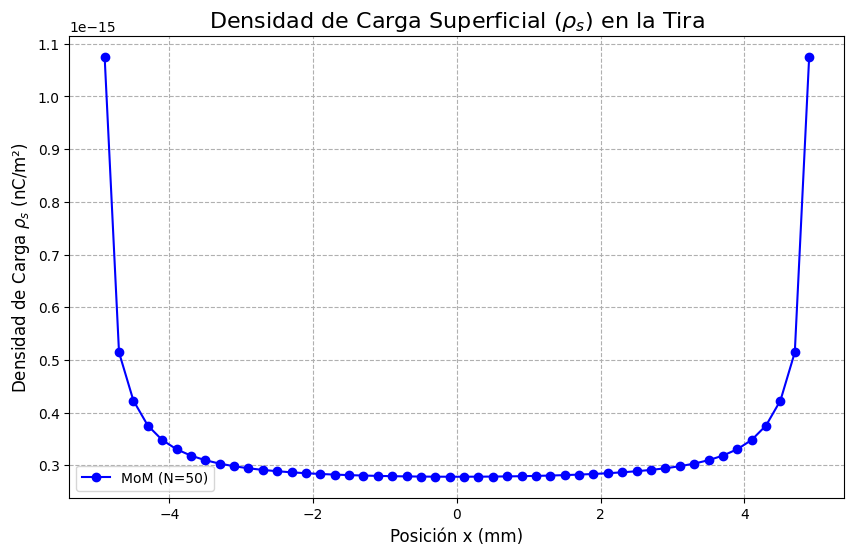

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Constantes del Problema (Ejemplo 16.5 / 16.8) ---
# Usamos los mismos valores geométricos
W = 10e-3     # Ancho de la tira (10 mm)
h = 1.6e-3    # Alto del dieléctrico (1.6 mm)
V0 = 10.0     # Potencial de la tira (10 V)
er = 4.3      # Permitividad relativa del dieléctrico

# Constantes físicas
e0 = 8.854e-12 # Permitividad del vacío (F/m)
epsilon = er * e0  # Permitividad del dieléctrico

# --- 2. Parámetros del Método de Momentos (MoM) ---
N = 50        # Número de segmentos (células) en la tira
              # Puedes aumentar N para más precisión

# --- 3. Discretización de la Geometría ---
dx = W / N                     # Ancho de cada segmento
x_centers = np.linspace(-W/2 + dx/2, W/2 - dx/2, N) # Centros de los segmentos

# --- 4. Construcción de la Matriz Z (Matriz de Acoplamiento) ---
# Z_mn = Potencial en el centro del segmento 'm'
#        debido a una densidad de carga unitaria en el segmento 'n'

Z = np.zeros((N, N))
g_factor = 1.0 / (2.0 * np.pi * epsilon)

for m in range(N):
    xm = x_centers[m] # Punto de prueba (centro de la celda 'm')

    for n in range(N):
        xn = x_centers[n] # Centro de la celda fuente 'n'

        if m == n:
            # --- Auto-término (m = n) ---
            # Usamos la integral analítica para la singularidad
            # Z_mm = (dx / (2*pi*eps)) * [1 - ln(dx/2) + ln(2h)]
            Z[m, n] = g_factor * dx * (1.0 - np.log(dx / 2.0) + np.log(2.0 * h))

        else:
            # --- Término de acoplamiento (m != n) ---
            # Aproximación de Colocación (Point Matching)
            # G(xm, xn) = G_fuente + G_imagen

            # 1. Potencial de la fuente (en xn, y=h)
            dist_source = np.abs(xm - xn)
            phi_source = -np.log(dist_source)

            # 2. Potencial de la imagen (en xn, y=-h)
            dist_image = np.sqrt((xm - xn)**2 + (2*h)**2)
            phi_image = np.log(dist_image) # (la imagen tiene carga opuesta, -rho)

            # Z_mn = G(xm, xn) * Ancho_segmento
            Z[m, n] = g_factor * (phi_source + phi_image) * dx

# --- 5. Construcción del Vector V (Vector de Potenciales Conocidos) ---
# El potencial en el centro de cada segmento es V0
V = np.full(N, V0)

# --- 6. Resolver el Sistema de Ecuaciones ---
# Z * rho = V  =>  rho = Z_inv * V
print("Resolviendo Z * rho = V...")
rho = np.linalg.solve(Z, V)
print("¡Resuelto!")

# --- 7. Calcular Capacitancia y Carga Total ---
# La carga en cada segmento es Q_n = rho_n * Area_n = rho_n * (dx * 1 metro)
# Asumimos 1 metro de longitud en z
Q_total = np.sum(rho * dx) # Carga total por unidad de longitud (C/m)
C_per_length = Q_total / V0 # Capacitancia por unidad de longitud (F/m)

print("\n--- Resultados del Método de Momentos ---")
print(f"Ancho (W): {W*1000} mm, Alto (h): {h*1000} mm, eps_r: {er}")
print(f"Número de segmentos (N): {N}")
print(f"Carga Total (Q/L): {Q_total * 1e12:.2f} pC/m")
print(f"Capacitancia (C/L): {C_per_length * 1e12:.2f} pF/m")
print("-------------------------------------------\n")

# --- 8. Graficar la Densidad de Carga ---
plt.figure(figsize=(10, 6))
# Convertir rho a pC/m^2 para una mejor visualización
# (rho es C/m^2, pero por unidad de longitud... C/m. Es C/m^2)
# El resultado 'rho' es la densidad superficial de carga (C/m^2)
plt.plot(x_centers * 1000, rho * 1e-9, 'bo-', label=f'MoM (N={N})')
plt.title('Densidad de Carga Superficial ($\\rho_s$) en la Tira', fontsize=16)
plt.xlabel('Posición x (mm)', fontsize=12)
plt.ylabel('Densidad de Carga $\\rho_s$ (nC/m²)', fontsize=12)
plt.grid(True, linestyle='--')
plt.legend()
plt.show()